# Wumpus World DQN
Autors: Peihang Xu, Micky Kumar, Elham Sadeey

# Basic Setup

## Import librarys 

In [1]:
from __future__ import print_function

# Can choose to use for different neural network setups
# from Environment_CNN import *
from Environment_dense import * 


import numpy as np
from IPython.display import clear_output
import random
from random import randint
from matplotlib import pylab as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Dense, Flatten, Activation
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import keras.backend as K
from keras import activations
from keras.utils import np_utils

import pickle
tf.__version__




'2.3.1'

## Check environment behaviours

In [2]:
game = Environment().initialize(4,4,0.2,True)[0]
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('TurnLeft')
game.applyAction('Shoot')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Climb')


print(game.visualize())
print(game.terminated)
print(game.agent.visitedlocations)
print(game.agent.stenchlocations)
print(game.agent.breezelocations)

    |    |    |    
    |    |Aw  |    
    |    |    |G   
    |    |    |    

False
[(2, 1), (0, 0), (2, 0), (2, 2), (1, 0)]
[(2, 1)]
[]


In [3]:

game = Environment().initialize(4,4,0.2,True)[0]
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Climb')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')
game.applyAction('Forward')


print(game.visualize())
print(game.terminated)
print(game.agent.visitedlocations)
print(game.agent.stenchlocations)
print(game.agent.breezelocations)
print(game.render_np()[72:78])

    |    |    |PW  
    |    |P   |G   
    |    |    |    
    |    |    |A   

False
[(1, 0), (2, 0), (3, 0), (0, 0)]
[]
[]
[0. 0. 1. 0. 1. 0.]


In [4]:
action_set = {
    0: 'Forward',
    1: 'TurnLeft',
    2: 'TurnRight',
    3: 'Grab',
    4: 'Climb',
    5: 'Shoot'
}


# All Dense Layers

## Create Model

In [5]:
input_d = 78
output_d = 6
learning_rate = 5*10**(-4)

def create_model():
    inputs = Input(shape=(input_d,))
    layer1 = Dense(512,activation='relu')(inputs)
    layer2 = Dense(128,activation='relu')(layer1)
    layer3 = Dense(128,activation='relu')(layer2)
    layer4 = Dense(128,activation='relu')(layer3)
    action = Dense(output_d,activation='linear')(layer4)
    return keras.Model(inputs=inputs, outputs=action)

In [6]:
model = create_model() 
model2 = create_model() 
model.summary()
model2.summary()
model2.set_weights(model.get_weights())
optimizer = Adam(learning_rate = learning_rate)
loss_function = MeanSquaredError()
model.compile(optimizer = optimizer, loss=loss_function)
model2.compile(optimizer = optimizer, loss=loss_function)
model2.set_weights(model.get_weights()) 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 78)]              0         
_________________________________________________________________
dense (Dense)                (None, 512)               40448     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 139,910
Trainable params: 139,910
Non-trainable params: 0
________________________________________________

## Training

In [7]:
# can use the following to turn off GPU training
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [8]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [9]:
import timeit
from collections import deque
from IPython.display import display, clear_output

epochs = 15000
mem_size = 10000000
batch_size = 128
replay = deque(maxlen=mem_size)
max_moves = 250 #1250
sync_freq = 500 #1500 
gamma = 0.85

epsilon_min = 0.03  # Minimum epsilon greedy parameter
epsilon0 = 0.9


win_num = 0
win_num_list = []
actions_list = []
losses = []
h = 0
j=0
for i in range(epochs):
    game = Environment().initialize(4,4,0.2,True)[0]
    losses_episode = []
    state1_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state1 = tf.convert_to_tensor(state1_, dtype=float, dtype_hint=None, name=None)
    status = 1
    mov = 0
    epsilon0 = epsilon0*0.999
    epsilon = max(epsilon0, epsilon_min)
    while(status == 1): 
        j += 1
        mov += 1
        qval = model(state1, training=False) 
        qval_ = qval
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,6)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.applyAction(action)
        state2_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state2 = tf.convert_to_tensor(state2_, dtype=float, dtype_hint=None, name=None)
        reward = game.agent.currentreward
        done = 1. if (game.terminated) else 0.
        exp =  (state1, action_, reward, state2, done) 
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size: 
            minibatch = random.sample(replay, batch_size) 
            state1_batch = tf.concat([s1 for (s1,a,r,s2,d) in minibatch],0) 
            action_batch = tf.constant([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = tf.constant([r for (s1,a,r,s2,d) in minibatch],dtype=float)
            state2_batch = tf.concat([s2 for (s1,a,r,s2,d) in minibatch],0)
            done_batch = tf.constant([d for (s1,a,r,s2,d) in minibatch])
            
            Q2 = model2(state2_batch,training=False) 
            Y = reward_batch + gamma * ((tf.constant(1.) - done_batch) * tf.math.reduce_max(Q2,axis=1)) #N
            masks = tf.one_hot(action_batch, 6)
                        
            with tf.GradientTape() as tape:
                Q1 = model(state1_batch) 
                Y_action = tf.reduce_sum(tf.multiply(Q1, masks), axis=1)
                loss = loss_function(Y, Y_action)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss.numpy())
            losses_episode.append(loss.numpy())
            
            if j % sync_freq == 0: 
                model2.set_weights(model.get_weights())
#                 print('!!!!!!!!!!!!sync happened!!!!!!!!!!!!')
                
        if game.terminated or mov > max_moves: #O
            status = 0
            mov = 0
            if len(losses_episode)!=0:
                print("Episode num: {}, average loss: {}".format(i, sum(losses_episode)/len(losses_episode)))
            if game.agent.totalreward>0 or game.agent.currentreward>0:
                print("Game won! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward, 
                                                                                                  game.agent.totalreward, game.agent.hasgold))
                win_num += 1
            else:
                print("Game lost! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward,
                                                                                                   game.agent.totalreward,game.agent.hasgold))
                if game.agent.currentreward == -1:
                    print("Last action:", action)
            if i%10 == 9:
                print("Attention! Win # in last 10 episodes:", win_num)
                win_num_list.append(win_num)
                win_num = 0
            if i%50 == 49:
                clear_output(wait=True)
losses = np.array(losses)





Episode num: 14950, average loss: 803.2121458699504
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: Climb
Episode num: 14951, average loss: 741.0380413921706
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: Forward
Episode num: 14952, average loss: 837.6690780094692
Game lost! Current reward: -1001, total reward: -1042, Agent has gold: False
Episode num: 14953, average loss: 232.056060579088
Game won! Current reward: 999, total reward: 991, Agent has gold: True
Episode num: 14954, average loss: 684.0873967228514
Game lost! Current reward: -1001, total reward: -1142, Agent has gold: False
Episode num: 14955, average loss: 684.5375314843718
Game lost! Current reward: -1001, total reward: -1199, Agent has gold: False
Episode num: 14956, average loss: 700.5859762338491
Game won! Current reward: 999, total reward: 987, Agent has gold: True
Episode num: 14957, average loss: 735.9310929360597
Game lost! Current reward:

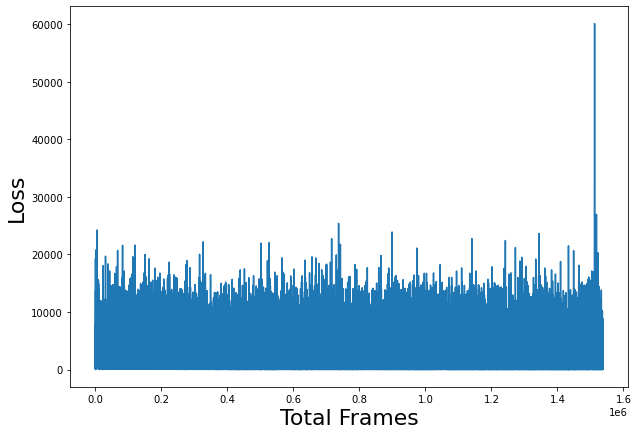

In [10]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Total Frames",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.show()

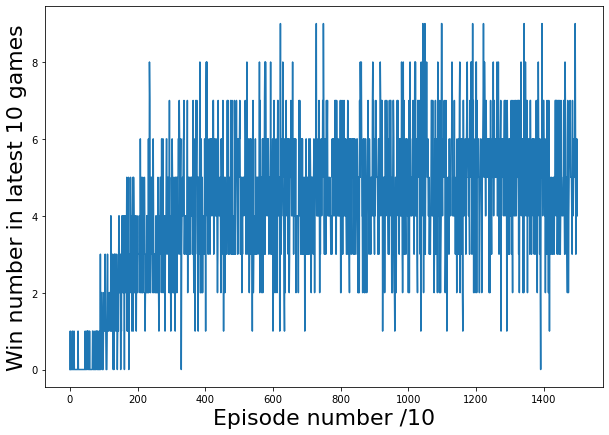

In [11]:
plt.figure(figsize=(10,7))
plt.plot(win_num_list)
plt.xlabel("Episode number /10",fontsize=22)
plt.ylabel("Win number in latest 10 games",fontsize=22)
plt.show()

In [12]:
model.save_weights('model_dense_78_512_128_128_128_epoch_15000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000.h5')


## Testing

In [7]:
model.load_weights('model_dense_78_512_128_128_128_epoch_15000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000.h5')

In [11]:
max_moves=250
def test_keras_model(model,display=True):
    clear_output(wait=True)
    i = 0
    test_game = Environment().initialize(4,4,0.2,True)[0]
    goldinPW = 1. if test_game.goldlocation == test_game.wumpuslocation or (test_game.goldlocation in test_game.pitlocations) else 0.
    stuck = 0
    die = 0
    winnogold = 0

    
    state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
    if display:
        print("Initial State:")
        print(test_game.visualize())
    status = 1
    while(status == 1):
        qval = model(state,training=False)
        qval_ = qval
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.applyAction(action)
        state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
        if display:
            print(test_game.visualize())
        reward = test_game.agent.currentreward
        total_reward = test_game.agent.totalreward
        if test_game.terminated:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (test_game.agent.totalreward))
            else:
                if goldinPW and action=='Climb':
                    status = 2
                    winnogold += 1.
                    if display:
                        print("Game won! Reward: %s" % (test_game.agent.totalreward),"choose to climb out without gold")
                else:    
                    status = 0
                    die = 1
                    if display:
                        print("Game LOST. Reward: %s" % (test_game.agent.totalreward))
        i += 1
        if (i > max_moves):
            stuck=1
            if display:
                print("Game lost; too many moves.")
            break
   
    win = True if status == 2 else False
    pitnum = [0,0,0,0,0]
    win_in_pitnum = [0,0,0,0,0]
    num_of_pits = len(test_game.pitlocations)
    if num_of_pits == 0:
        pitnum[0]=1.
        if win:
            win_in_pitnum[0]=1.
    if num_of_pits == 1:
        pitnum[1]=1.
        if win:
            win_in_pitnum[1]=1.
    if num_of_pits == 2:
        pitnum[2]=1.
        if win:
            win_in_pitnum[2]=1.
    if num_of_pits == 3:
        pitnum[3]=1.
        if win:
            win_in_pitnum[3]=1.
    if num_of_pits >= 4:
        pitnum[4]=1.
        if win:
            win_in_pitnum[4]=1.
#     print("Reward:", test_game.agent.totalreward, win,action)
#     print(test_game.visualize())
    return win,total_reward,goldinPW,stuck,die,np.array(pitnum),np.array(win_in_pitnum),winnogold

In [15]:
# sample game
test_keras_model(model,display=True)

Initial State:
    |W   |P   |    
    |    |    |    
    |    |    |G   
A   |    |    |    

Move #: 0; Taking action: Forward
    |W   |P   |    
    |    |    |    
    |    |    |G   
    |A   |    |    

Move #: 1; Taking action: TurnLeft
    |W   |P   |    
    |    |    |    
    |    |    |G   
    |A   |    |    

Move #: 2; Taking action: Forward
    |W   |P   |    
    |    |    |    
    |A   |    |G   
    |    |    |    

Move #: 3; Taking action: Forward
    |W   |P   |    
    |A   |    |    
    |    |    |G   
    |    |    |    

Move #: 4; Taking action: Shoot
    |w   |P   |    
    |A   |    |    
    |    |    |G   
    |    |    |    

Move #: 5; Taking action: Forward
    |Aw  |P   |    
    |    |    |    
    |    |    |G   
    |    |    |    

Move #: 6; Taking action: TurnRight
    |Aw  |P   |    
    |    |    |    
    |    |    |G   
    |    |    |    

Move #: 7; Taking action: TurnRight
    |Aw  |P   |    
    |    |    |    
    |    |    |G   
  

(True,
 964,
 0.0,
 0,
 0,
 array([0., 1., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 0)

In [18]:
max_games = 1000
wins = 0
reward = 0
goldinpwtotal = 0
stucktotal = 0
dietotal = 0
winnogoldtotal = 0
pitnumtotal = np.array([0,0,0,0,0])
winpitnumtotal = np.array([0,0,0,0,0])

for i in range(max_games):
    print('currently palying game:',i+1)
    win,treward,goldinpw,stuck,die,pitnum,winpitnum,winnogold = test_keras_model(
        model, display=False)
    reward += treward
    goldinpwtotal += goldinpw
    dietotal += die
    stucktotal += stuck
    pitnumtotal = pitnumtotal+pitnum
    winpitnumtotal = winpitnumtotal + winpitnum
    winnogoldtotal += winnogold
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
avg_reward = reward/max_games
print("Games played: {0}, number of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
print("Average reward: {}".format(avg_reward))
print("Games with gold in pits/wumpus: {0}, win rate in other games: {1}".format(goldinpwtotal,wins/(max_games-goldinpwtotal)))
print("Games stuck: {}, games died: {}".format(stucktotal,dietotal))
print("Games with pits number 0,1,2,3 and 4+: {}, win numbers in those games: {}, win ratio: {}".format(pitnumtotal,
                                                                                                        winpitnumtotal,
                                                                                                        winpitnumtotal/pitnumtotal))
print("Climb out without gold: {}, ratio: {}".format(winnogoldtotal, winnogoldtotal/goldinpwtotal))

Games played: 1000, number of wins: 509
Win percentage: 50.9%
Average reward: 277.037
Games with gold in pits/wumpus: 268.0, win rate in other games: 0.6953551912568307
Games stuck: 380, games died: 111
Games with pits number 0,1,2,3 and 4+: [134. 312. 280. 184.  90.], win numbers in those games: [130. 192. 117.  53.  17.], win ratio: [0.97014925 0.61538462 0.41785714 0.28804348 0.18888889]
Climb out without gold: 0, ratio: 0.0


Text(0, 0.5, 'Winning rate')

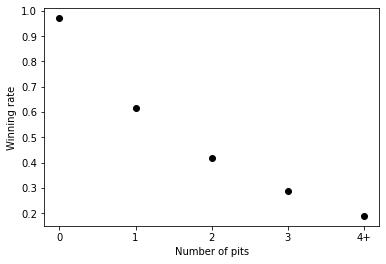

In [19]:
plt.plot(['0','1','2','3','4+'], winpitnumtotal/pitnumtotal, 'o', color='black')
plt.xlabel('Number of pits')
plt.ylabel('Winning rate')

# CNN Layers + Dense Layers

Note: to run the training below, make sure you restart the kernel, load the `Environment_CNN` instead of `Environment_dense`, and re-run the Basic setup part

## Create Model

In [5]:
# You have to run this to make sure GPU works for CNN layers
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess =  tf.compat.v1.Session(config=config)

In [6]:
input_d = 4,4,18
output_d = 6
learning_rate = 5*10**(-4)
def create_CNN_model():
    # Network defined by the Deepmind paper
    inputs = Input(shape=input_d)

    # Convolutions on the frames on the screen
    layer1 = Conv2D(filters=54,kernel_size=(1,1),padding='SAME',activation='relu')(inputs)
#     layer2 = tf.keras.layers.Conv2D(filters=14,kernel_size=(1,1),activation='relu')(layer1)
    layer3 = Flatten()(layer1)
    layer4 = Dense(128,activation='relu')(layer3)
    layer5 = Dense(128,activation='relu')(layer4)
    layer6 = Dense(64,activation='relu')(layer5)
    action = Dense(6,activation='linear')(layer6)

    

    return keras.Model(inputs=inputs, outputs=action)

In [7]:

model = create_CNN_model() 
model2 = create_CNN_model() 
model.summary()
model2.summary()
model2.set_weights(model.get_weights())
optimizer = Adam(learning_rate = learning_rate)
loss_function = MeanSquaredError()
model.compile(optimizer = optimizer, loss=loss_function)
model2.compile(optimizer = optimizer, loss=loss_function)
model2.set_weights(model.get_weights()) 



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 4, 18)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 54)          1026      
_________________________________________________________________
flatten (Flatten)            (None, 864)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               110720    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

## Training

In [11]:
from collections import deque
from IPython.display import display, clear_output

epochs = 15000
mem_size = 10000000
batch_size = 128
replay = deque(maxlen=mem_size)
max_moves = 250 #1250
sync_freq = 500 #1500 
gamma = 0.85

epsilon_min = 0.03  # Minimum epsilon greedy parameter
epsilon0 = 0.9


win_num = 0
win_num_list = []
actions_list = []
losses = []
h = 0
j=0
for i in range(epochs):
    game = Environment().initialize(4,4,0.2,True)[0]
    losses_episode = []
    state1_ = game.render_np().reshape(1,4,4,18) + np.random.rand(1,4,4,18)/100.0
    state1 = tf.convert_to_tensor(state1_, dtype=float, dtype_hint=None, name=None)
    status = 1
    mov = 0
    epsilon0 = epsilon0*0.999
    epsilon = max(epsilon0, epsilon_min)
    while(status == 1): 
        j += 1
        mov += 1
        qval = model(state1, training=False) 
        qval_ = qval
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,6)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.applyAction(action)
        state2_ = game.render_np().reshape(1,4,4,18) + np.random.rand(1,4,4,18)/100.0
        state2 = tf.convert_to_tensor(state2_, dtype=float, dtype_hint=None, name=None)
        reward = game.agent.currentreward
        done = 1. if (game.terminated) else 0.
        exp =  (state1, action_, reward, state2, done) 
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size: 
            minibatch = random.sample(replay, batch_size) 
            state1_batch = tf.concat([s1 for (s1,a,r,s2,d) in minibatch],0) 
            action_batch = tf.constant([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = tf.constant([r for (s1,a,r,s2,d) in minibatch],dtype=float)
            state2_batch = tf.concat([s2 for (s1,a,r,s2,d) in minibatch],0)
            done_batch = tf.constant([d for (s1,a,r,s2,d) in minibatch])
            
            Q2 = model2(state2_batch,training=False) 
            Y = reward_batch + gamma * ((tf.constant(1.) - done_batch) * tf.math.reduce_max(Q2,axis=1)) #N
            masks = tf.one_hot(action_batch, 6)
                        
            with tf.GradientTape() as tape:
                Q1 = model(state1_batch) 
                Y_action = tf.reduce_sum(tf.multiply(Q1, masks), axis=1)
                loss = loss_function(Y, Y_action)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss.numpy())
            losses_episode.append(loss.numpy())
            
            if j % sync_freq == 0: 
                model2.set_weights(model.get_weights())
#                 print('!!!!!!!!!!!!sync happened!!!!!!!!!!!!')
                
        if game.terminated or mov > max_moves: #O
            status = 0
            mov = 0
            if len(losses_episode)!=0:
                print("Episode num: {}, average loss: {}".format(i, sum(losses_episode)/len(losses_episode)))
            if game.agent.totalreward>0 or game.agent.currentreward>0:
                print("Game won! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward, 
                                                                                                  game.agent.totalreward, game.agent.hasgold))
                win_num += 1
            else:
                print("Game lost! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward,
                                                                                                   game.agent.totalreward,game.agent.hasgold))
                if game.agent.currentreward == -1:
                    print("Last action:", action)
            if i%10 == 9:
                print("Attention! Win # in last 10 episodes:", win_num)
                win_num_list.append(win_num)
                win_num = 0
            if i%50 == 49:
                clear_output(wait=True)
losses = np.array(losses)





Episode num: 14950, average loss: 683.3725284637208
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: Shoot
Episode num: 14951, average loss: 831.9560276806592
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: Grab
Episode num: 14952, average loss: 375.5530380975632
Game won! Current reward: 999, total reward: 969, Agent has gold: True
Episode num: 14953, average loss: 855.6180185016833
Game won! Current reward: 999, total reward: 971, Agent has gold: True
Episode num: 14954, average loss: 809.7443020173481
Game lost! Current reward: -1001, total reward: -1112, Agent has gold: False
Episode num: 14955, average loss: 760.3567023557775
Game won! Current reward: 999, total reward: 932, Agent has gold: True
Episode num: 14956, average loss: 569.5990159084123
Game lost! Current reward: -1, total reward: -261, Agent has gold: False
Last action: TurnLeft
Episode num: 14957, average loss: 571.6151528377457
Game lost! Curre

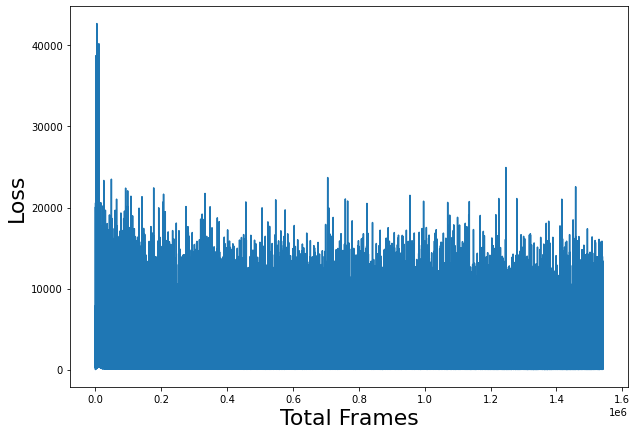

In [12]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Total Frames",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.show()

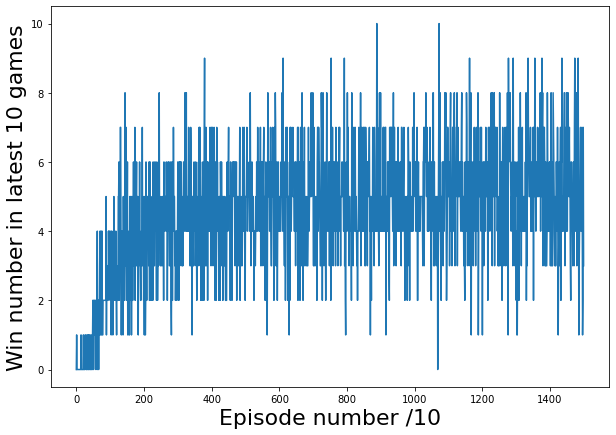

In [13]:
plt.figure(figsize=(10,7))
plt.plot(win_num_list)
plt.xlabel("Episode number /10",fontsize=22)
plt.ylabel("Win number in latest 10 games",fontsize=22)
plt.show()

In [14]:
model.save_weights('model_CNN_54_1_1_128_128_64_epoch_15000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000.h5')

## Testing

In [8]:
model.load_weights('model_CNN_54_1_1_128_128_64_epoch_15000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000.h5')

In [9]:
max_moves=250
def test_keras_model(model, display=True):
    clear_output(wait=True)
    i = 0
    test_game = Environment().initialize(4,4,0.2,True)[0]
    goldinPW = 1. if test_game.goldlocation == test_game.wumpuslocation or (test_game.goldlocation in test_game.pitlocations) else 0.
    stuck = 0
    die = 0
    winnogold = 0

    
    state_ = test_game.render_np().reshape(1,4,4,18) + np.random.rand(1,4,4,18)/100.0
    state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
    if display:
        print("Initial State:")
        print(test_game.visualize())
    status = 1
    while(status == 1):
        qval = model(state,training=False)
        qval_ = qval
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.applyAction(action)
        state_ = test_game.render_np().reshape(1,4,4,18) + np.random.rand(1,4,4,18)/100.0
        state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
        if display:
            print(test_game.visualize())
        reward = test_game.agent.currentreward
        total_reward = test_game.agent.totalreward
        if test_game.terminated:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (test_game.agent.totalreward))
            else:
                if goldinPW and action=='Climb':
                    status = 2
                    winnogold += 1.
                    if display:
                        print("Game won! Reward: %s" % (test_game.agent.totalreward),"choose to climb out without gold")
                else:    
                    status = 0
                    die = 1
                    if display:
                        print("Game LOST. Reward: %s" % (test_game.agent.totalreward))
        i += 1
        if (i > max_moves):
            stuck=1
            if display:
                print("Game lost; too many moves.")
            break
   
    win = True if status == 2 else False
    pitnum = [0,0,0,0,0]
    win_in_pitnum = [0,0,0,0,0]
    num_of_pits = len(test_game.pitlocations)
    if num_of_pits == 0:
        pitnum[0]=1.
        if win:
            win_in_pitnum[0]=1.
    if num_of_pits == 1:
        pitnum[1]=1.
        if win:
            win_in_pitnum[1]=1.
    if num_of_pits == 2:
        pitnum[2]=1.
        if win:
            win_in_pitnum[2]=1.
    if num_of_pits == 3:
        pitnum[3]=1.
        if win:
            win_in_pitnum[3]=1.
    if num_of_pits >= 4:
        pitnum[4]=1.
        if win:
            win_in_pitnum[4]=1.
#     print("Reward:", test_game.agent.totalreward, win,action)
#     print(test_game.visualize())
    return win,total_reward,goldinPW,stuck,die,np.array(pitnum),np.array(win_in_pitnum),winnogold

In [10]:
max_games = 1000
wins = 0
reward = 0
goldinpwtotal = 0
stucktotal = 0
dietotal = 0
winnogoldtotal = 0
pitnumtotal = np.array([0,0,0,0,0])
winpitnumtotal = np.array([0,0,0,0,0])

for i in range(max_games):
    print('currently palying game:',i+1)
    win,treward,goldinpw,stuck,die,pitnum,winpitnum,winnogold = test_keras_model(
        model, display=False)
    reward += treward
    goldinpwtotal += goldinpw
    dietotal += die
    stucktotal += stuck
    pitnumtotal = pitnumtotal+pitnum
    winpitnumtotal = winpitnumtotal + winpitnum
    winnogoldtotal += winnogold
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
avg_reward = reward/max_games
print("Games played: {0}, number of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
print("Average reward: {}".format(avg_reward))
print("Games with gold in pits/wumpus: {0}, win rate in other games: {1}".format(goldinpwtotal,wins/(max_games-goldinpwtotal)))
print("Games stuck: {}, games died: {}".format(stucktotal,dietotal))
print("Games with pits number 0,1,2,3 and 4+: {}, win numbers in those games: {}, win ratio: {}".format(pitnumtotal,
                                                                                                        winpitnumtotal,
                                                                                                        winpitnumtotal/pitnumtotal))
print("Climb out without gold: {}, ratio: {}".format(winnogoldtotal, winnogoldtotal/goldinpwtotal))

Games played: 1000, number of wins: 532
Win percentage: 53.2%
Average reward: 373.585
Games with gold in pits/wumpus: 275.0, win rate in other games: 0.7337931034482759
Games stuck: 437, games died: 31
Games with pits number 0,1,2,3 and 4+: [129. 296. 335. 174.  66.], win numbers in those games: [120. 195. 153.  47.  17.], win ratio: [0.93023256 0.65878378 0.45671642 0.27011494 0.25757576]
Climb out without gold: 0, ratio: 0.0


Text(0, 0.5, 'Winning rate')

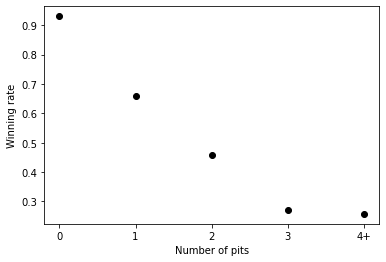

In [11]:
plt.plot(['0','1','2','3','4+'],winpitnumtotal/pitnumtotal, 'o', color='black')
plt.xlabel('Number of pits')
plt.ylabel('Winning rate')